In [19]:
import json
from pymongo import MongoClient
import pandas as pd
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6, inferno
import numpy as np
from bokeh.models import ColumnDataSource
from bokeh.io import show, output_notebook
from scipy.spatial import distance
import matplotlib.pyplot as plt
from bokeh.models import HoverTool
import pickle

import urllib
import zipfile
import os
import scipy.io
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pykalman import KalmanFilter

from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

In [20]:
# Make connection to MongoDB Server
MONGODB_URL=''
client = MongoClient(MONGODB_URL)

In [21]:
# Get list of collections under datamanager folder
database_name = 'datamanager'
database = client[database_name]
collection = database.list_collection_names(include_system_collections=False)
for collect in collection:
    print(collect)

airport_wait_time
clientAiports
flightStatuses
flightTracks
airports
_schema
equipments
requests
airlines
runs


In [22]:
# Get list of all headings under the currently chosen collection (flightTracks)
db = client.datamanager
curs=db.flightTracks.find()
for c in curs[0]:
    print(c)

_id
flightId
bearing
heading
flightNumber
delayMinutes
departureAirportFsCode
departureDate
arrivalAirportFsCode
request_id
carrierFsCode
equipment
tailNumber
callsign
positions


In [23]:
# # Peak at the data in the currently chosen collection (flightTracks) by looking at first entry
# db = client.datamanager
# curs=db.flightTracks.find()
# for c in curs[0:1]:
#     print(c)

In [24]:
# Look at how many distinct entries exist for each of the headings in currently chosen collection (flightTracks)

# info=db.flightTracks.distinct('_id') # 3761 found, ObjectID's inside
# info=db.flightTracks.distinct('flightId') # 3761 found, integers inside
# info=db.flightTracks.distinct('bearing') # 3727 found, floats inside
# info=db.flightTracks.distinct('heading') # 3748 found, floats inside
# info=db.flightTracks.distinct('delayMinutes') # 167 found, integers inside
# info=db.flightTracks.distinct('departureAirportFsCode') # 244 found, airport name strings inside
# info=db.flightTracks.distinct('departureDate') # 2204 found, date dicts inside
# info=db.flightTracks.distinct('arrivalAirportFsCode') # 192 found, airport name strings inside
# info=db.flightTracks.distinct('request_id') # 68 found, ObjectID's inside
# info=db.flightTracks.distinct('carrierFsCode') # 142 found, carrier code strings inside
info=db.flightTracks.distinct('equipment') # 70 found, equipment code strings inside
# info=db.flightTracks.distinct('tailNumber') # 2268 found, tail number strings inside
# info=db.flightTracks.distinct('callsign') # 1205 found, call sign strings inside

# info=db.flightTracks.distinct('positions') # Too large to check as each contains all data along the way

print(len(info))
print(info)

103
['359', '789', '388', '77W', '32B', '744', '788', '333', '772', '321', '75W', '74H', '320', '75C', '332', '7S8', '77X', '74Y', '74N', '77L', '319', '76Y', 'M1F', '76V', '32A', '73W', 'E75', '76W', '73H', '75T', '74E', '73J', '76C', '32Q', '343', '32N', '738', '76E', '31B', '773', '735', 'CR2', 'CR7', '733', 'A81', 'CCX', '32S', 'D1X', '781', '737', 'E90', '717', '736', 'CN7', 'ABY', 'CNJ', '73G', 'CJL', '346', '763', 'D1Y', 'PL2', 'EP3', 'AB3', 'BE9', '33X', 'CN2', '75D', '739', 'CJ8', 'C28', 'CL5', 'LRJ', '330', '76X', 'GJ4', 'E95', 'CRJ', 'EM2', '752', '73S', '747', '290', 'H24', 'CL3', 'T20', 'EM4', 'D20', 'BET', 'EP1', '74F', 'CCJ', 'GJ6', 'GR2', 'DF3', '339', 'CR9', '734', 'CR1', '787', '295', 'GRS', 'H25']


In [25]:
# Create list of all equipment
equip_list = db.flightTracks.distinct('equipment')

In [26]:
# list(db.flightTracks.find({'equipment':'BET'}))

In [27]:
# Definition returns minimum euclidean distance between provided node and target node
def closest_node(comp_node, nodes):
    # Note nodes is a list of tuples
    node_list = []
    if len(nodes[0])>2:
        for index,node in enumerate(nodes):
            node_list.append((node[0],node[1]))
    else:
        node_list = nodes
    closest_index = distance.cdist([comp_node], node_list).argmin()
#     print(nodes[closest_index])
    return nodes[closest_index]

In [67]:
# Filter currently chosen collection (flightTracks) by chosen entry from above and display in dataframe
# In this box consider only those flights departing from LAX

def read_in_flights(filter_code,lat_lon_range):
    # No filtering is filter_code=0
    # Filter by departing from LAX is filter_code=1
    # Filter by arriving to LAX is filter_code=2

    lax_coord = [33.9416, -118.4085]
    # Range of latitudes and longitudes around LAX to include
    lat_min = lax_coord[0] - lat_lon_range
    lat_max = lax_coord[0] + lat_lon_range
    lon_min = lax_coord[1] - lat_lon_range
    lon_max = lax_coord[1] + lat_lon_range

    df = pd.DataFrame()
    
    num_flagged = 0
    # Go through each type of equipment one at a time
    for i,elem in enumerate(equip_list):
        print('Going through equipment-type %i of %i' %(i,len(equip_list)))

        if filter_code == 0:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem})),
                              columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                       'departureDate','positions'])
            start_index = 0
            end_index = -1
        elif filter_code == 1:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem ,
                                                     'departureAirportFsCode':'LAX'})),
                         columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                  'departureDate','positions'])
            start_index = -200
            end_index = -1
        elif filter_code == 2:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem ,
                                                         'arrivalAirportFsCode':'LAX'})),
                             columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                      'departureDate','positions'])
            start_index = 0
            end_index = 60
            
        num_flagged += data.shape[0]
            
        # No go through each flight within this type of equipment
        out = []
        out_dates = []
        first_date_rec = []
        first_date_pos = []
        last_date_rec = []
        last_date_pos = []
        skip_list = [True] * data.shape[0]
        # Go through each flight
        for index in range(data.shape[0]):
            temp_df = pd.DataFrame(data.positions[index],
                                   columns=['lat','lon','altitudeFt','date','course','speedMph',
                                           'vrateMps']).iloc[start_index:end_index]
            
            # Store as list of tuples
            temp_df['points'] = list(zip(temp_df.lat,
                                         temp_df.lon,
                                         temp_df.altitudeFt,
                                         temp_df.date,
                                        temp_df.course,
                                        temp_df.speedMph))
            
            if len(temp_df)==0:
                skip_list[index] = False
            else:
                # Only include if flight contains points near LAX
                near_node=closest_node(lax_coord, list(zip(temp_df.lat,temp_df.lon)))
                if (near_node[0]<lat_min or near_node[0]>lat_max):
                    skip_list[index] = False
                if (near_node[1]<lon_min or near_node[1]>lon_max):
                    skip_list[index] = False

#             first_date_rec.append(temp_df.date.min())
#             last_date_rec.append(temp_df.date.max())
#             first_date_pos.append((temp_df.lat.loc[temp_df.date==temp_df.date.min()].values[0],
#                                   temp_df.lon.loc[temp_df.date==temp_df.date.min()].values[0]))
#             last_date_pos.append((temp_df.lat.loc[temp_df.date==temp_df.date.max()].values[0],
#                                   temp_df.lon.loc[temp_df.date==temp_df.date.max()].values[0]))
            
            # Append list of tuples for particular plane
            out.append(temp_df.points.values)
            out_dates.append(data.departureDate[index]['dateUtc'])
            
        # Skip if empty
        if len(data)==0:
            continue
            
#         print(data.shape)
#         print(len(out))
        # Add these tuples to the original dataframe and remove the positions column
        data['points'] = out
        data['date'] = out_dates
        ######## Uncomment below if investigating this #########
#         data['First_Date_Rec'] = first_date_rec
#         data['Last_Date_Rec'] = last_date_rec
#         data['First_Pos_Rec'] = first_date_pos
#         data['Last_Pos_Rec'] = last_date_pos
        
        # Before returning filter out those rows flagged as being skipped
        data = data[skip_list]
        
        data.drop(columns=['positions'],inplace=True)
        # Before moving to next type of equipment merge this with the master dataframe
        df = pd.concat([df, data], axis=0, sort=False)
    
    
    ###### Split departure date into multiple features (Uncomment if investigating this) ########
#     if not df.empty: # Below only makes sense if at least one flight found 
#         df['dep_date'] = pd.to_datetime(df['date'])
#         df['dep_year'] = df['dep_date'].dt.year 
#         df['dep_month'] = df['dep_date'].dt.month 
#         df['dep_day'] = df['dep_date'].dt.day 
#         df['dep_hour'] = df['dep_date'].dt.hour 
#         df['dep_minute'] = df['dep_date'].dt.minute 

    df.reset_index(inplace=True)
    return df, num_flagged


In [68]:
# filter_code = 1 # For departing from LAX
# lat_lon_range = 0.5 # Range around LAX to include for filtering
# dep_LAX_df, num_flagged = read_in_flights(filter_code,lat_lon_range)

# print('In total %i flights found for investigated' % num_flagged)
# print('In total %i flights were found for chosen filtering' %dep_LAX_df.shape[0])
# dep_LAX_df.head(1)

Going through equipment-type 0 of 103


AttributeError: 'float' object has no attribute 'cdist'

In [ ]:
# Save list of valid flights departing from LAX so we don't have to recalculate each time
pickle_out = open("dep_LAX_df.pickle","wb")
pickle.dump(dep_LAX_df, pickle_out)
pickle_out.close()

In [ ]:
# # Load list of valid flights departing from LAX if desired
# pickle_in = open("arr_LAX_df.pickle","rb")
# dep_LAX_df = pickle.load(pickle_in)

In [30]:
filter_code = 2 # For arriving to LAX
lat_lon_range = 0.5 # Range around LAX to include for filtering
arr_LAX_df,num_flagged = read_in_flights(filter_code,lat_lon_range)

print('In total %i flights found for investigated' % num_flagged)
print('In total %i flights were found for chosen filtering' %arr_LAX_df.shape[0])
arr_LAX_df.head(1)

Going through equipment-type 0 of 103
Going through equipment-type 1 of 103
Going through equipment-type 2 of 103
Going through equipment-type 3 of 103
Going through equipment-type 4 of 103
Going through equipment-type 5 of 103
Going through equipment-type 6 of 103
Going through equipment-type 7 of 103
Going through equipment-type 8 of 103
Going through equipment-type 9 of 103
Going through equipment-type 10 of 103
Going through equipment-type 11 of 103
Going through equipment-type 12 of 103
Going through equipment-type 13 of 103
Going through equipment-type 14 of 103
Going through equipment-type 15 of 103
Going through equipment-type 16 of 103
Going through equipment-type 17 of 103
Going through equipment-type 18 of 103
Going through equipment-type 19 of 103
Going through equipment-type 20 of 103
Going through equipment-type 21 of 103
Going through equipment-type 22 of 103
Going through equipment-type 23 of 103
Going through equipment-type 24 of 103
Going through equipment-type 25 of 

index                       _id departureAirportFsCode  \
0     71  5d1e147af29131e74d8d51fa                    SIN   

  arrivalAirportFsCode equipment  \
0                  LAX       359   

                                       departureDate  \
0  {'dateLocal': '2019-07-04T20:55:00.000', 'date...   

                                              points                      date  
0  [(33.9922, -118.236, 2572.0, 2019-07-05T04:24:...  2019-07-04T12:55:00.000Z

In [31]:
# Save list of valid flights arrived to LAX so we don't have to recalculate each time
pickle_out = open("arr_LAX_df.pickle","wb")
pickle.dump(arr_LAX_df, pickle_out)
pickle_out.close()

In [86]:
# Load list of valid flights arrived to LAX if desired
pickle_in = open("arr_LAX_df.pickle","rb")
arr_LAX_df = pickle.load(pickle_in)

In [ ]:
# filter_code = 0 # For no filtering
# lat_lon_range = 0.5 # Range around LAX to include for filtering
# full_df,num_flagged = read_in_flights(filter_code,lat_lon_range)

# print('In total %i flights found for investigated' % num_flagged)
# print('In total %i flights were found for chosen filtering' %full_df.shape[0])
# full_df.head(1)

In [99]:
# # Read in the standard and arrival procedures from the file

# f = open("/Users/bryan/Box Sync/_Airport-Planning-Solutions/28DaySubscription_Effective_2019-06-20/STARDP.txt", "r")
# prev_code = 'S0000'
# code_list = []
# name_list = []
# proc_vers_list = []

# lax_coord = [33.9416, -118.4085]
# lat_lon_range = .1
# # Range of latitudes and longitudes around LAX to include
# lat_min = lax_coord[0] - lat_lon_range
# lat_max = lax_coord[0] + lat_lon_range
# lon_min = lax_coord[1] - lat_lon_range
# lon_max = lax_coord[1] + lat_lon_range

# pos_tuple_list = []
# for line in f:
    
#     line = line.split()
    
#     # Skip if empty
#     if len(line)==0:
#         continue
        
#     code = line[0]
#     code_list.append(code)
    
#     # Check if we are going on to a new procedure
#     if not (code==prev_code): # Meaning we hit a new procedure
#         # If line longer then usual grab new name for procedure (if provided)
#         if len(line)>4:
#             name = ' '.join([line[-2],line[-1]])
#             vers_num = 1
#         proc_vers = 'V' + str(vers_num)
#     elif len(line)>4: # Hits this if we hit new procedure under same code
#         vers_num += 1
#         proc_vers = 'V' + str(vers_num)
        
    
#     # Save current name
#     name_list.append(name)
#     proc_vers_list.append(proc_vers)
    
#     # Update as previous code
#     prev_code = code
        
#     coord_piece = line[2]
#     lat_piece = coord_piece[0:8]
#     if lat_piece[0]=='N':
#         lat_piece = float(lat_piece[1:8])/(10**5)
#     else:
#         lat_piece = -float(lat_piece[1:8])/(10**5)

#     lon_piece = coord_piece[8:17]
#     if lon_piece[0]=='E':
#         lon_piece = float(lon_piece[1:8])/(10**4)
#     else:
#         lon_piece = -float(lon_piece[1:8])/(10**4)
    
#     pos_name = coord_piece[17:]
#     pos_tuple_list.append((lat_piece,lon_piece,pos_name))

# # Turn into Pandas DataFrame
# STARS_df = pd.DataFrame({'Code':code_list, 'Name':name_list, 'Proc_Variation':proc_vers_list,
#                          'Positions':pos_tuple_list})
# # Groupby Code and Name and turn Positions into list of tuples
# STARS_df=pd.DataFrame(STARS_df.groupby(['Code','Name','Proc_Variation'])['Positions'].apply(list))
# STARS_df.reset_index(level=['Code', 'Name', 'Proc_Variation'],inplace=True)

# # Now filter out all procedures which do not correspond to LAX
# skip_list = [True] * STARS_df.shape[0]
# for index in range(STARS_df.shape[0]):
#     temp_series = STARS_df.loc[index]
#     pos_list = temp_series[3]
    
#     # Only include if flight contains points near LAX
#     near_node=closest_node(lax_coord, pos_list)
#     if (near_node[0]<lat_min or near_node[0]>lat_max):
#         skip_list[index] = False
#     if (near_node[1]<lon_min or near_node[1]>lon_max):
#         skip_list[index] = False
# # Before returning filter out those rows flagged as being skipped
# STARS_df = STARS_df[skip_list]
# STARS_df.reset_index(inplace=True,drop = True)

# # print(STARS_df.shape)
# STARS_df.head(10)

In [100]:
# print(list(STARS_df.Name))
# print(STARS_df.loc[STARS_df.Name=='BIGBR THREE'])

In [101]:
# # Range of planes to plot
# plot_min=0
# # plot_max=347
# plot_max = STARS_df.shape[0]

# p = figure(title="STARS Trajectories")
# color_mapper = linear_cmap('index', inferno(256), plot_min, plot_max)

# for i in range(plot_min,plot_max):

#     # Overlay all flights on each other
#     temp_df = STARS_df.iloc[i-1:i]
# #     print(temp_df.Code.values[0])
    
#     # Gather list of latitude and longitude points for each flight separately
#     for elem in temp_df.Positions:
#         lat = [item[0] for item in elem]
#         lon = [item[1] for item in elem]
#         pos_name = [item[2] for item in elem]
#         proc_order = list(range(len(elem)))
        
#         index_list = np.ones(len(lat))*i
#         proc_name_list = [temp_df.Name.values[0]]*len(lat)
#         source = ColumnDataSource(
#             data=dict(lat=lat,
#                       lon=lon,
#                       pos_name=pos_name,
#                       proc_order=proc_order,
#                       proc_name_list=proc_name_list,
#                       index=index_list)
#         )
        
#         p.line(lon, lat, line_width=2)
#         p.circle(x="lon", y="lat", size=9, fill_alpha=0.1, source=source, color=color_mapper, name="foo")

# # Implement interactivity
# my_hover = HoverTool(names=["foo"])
# my_hover.tooltips = [('Longitude','@lon'),('Latitude', '@lat'),('Proc Step Num','@proc_order'),
#                      ('Position Name','@pos_name'),('Procedure Name','@proc_name_list')]
# p.add_tools(my_hover)
    
# output_notebook()  
# show(p)

In [102]:
# print(np.unique(dep_LAX_df.dep_day))
# plt.plot()
# dep_LAX_df.dep_hour.hist(figsize=(10,10),bins=24)
# plt.title('Departing Hour For Flights From LAX')
# plt.xlabel('Time (UTC)')

In [103]:
# full_df['date'] = pd.to_datetime(full_df['date'])
# full_df['year'] = full_df['date'].dt.year 
# full_df['month'] = full_df['date'].dt.month 
# full_df['day'] = full_df['date'].dt.day 
# full_df['hour'] = full_df['date'].dt.hour 
# full_df['minute'] = full_df['date'].dt.minute 

# print(np.unique(full_df.year))
# print(np.unique(full_df.month))
# print(np.unique(full_df.day))
# print(np.unique(full_df.hour))
# # full_df.head()

In [394]:
# Make copy of dataframe to plot and select equipment type to examine
df_plot = arr_LAX_df.copy(deep=True)

# Range of planes to plot
plot_min=0
plot_max=1000

p = figure(title="Flight Trajectories Arriving To LAX")

# color_mapper = linear_cmap('index', 'Viridis256', 0, df_plot.shape[0])
color_mapper = linear_cmap('index', inferno(256), plot_min, plot_max)

print('There are %i different trajectories chosen for plotting' %(plot_max-plot_min))

for i in range(plot_min,plot_max):

    # Overlay all flights on each other
    temp_df = df_plot.iloc[i-1:i]
    
    # Gather list of latitude and longitude points for each flight separately
    for elem in temp_df.points:
        lat = [item[0] for item in elem]
        lon = [item[1] for item in elem]
        
        index_list = np.ones(len(lat))*i
        source = ColumnDataSource(
            data=dict(lat=lat,
                      lon=lon,
                      index=index_list)
        )

        p.circle(x="lon", y="lat", size=2, fill_alpha=0.1, source=source, color=color_mapper)

output_notebook()  
show(p)

There are 1000 different trajectories chosen for plotting


Loading BokehJS ...

In [ ]:
# from bokeh.models import BasicTicker, ColorBar, LinearColorMapper

# to_inves_df = dep_LAX_df.copy(deep=True)
# to_inves = pd.DataFrame({'First_Date_Rec':to_inves_df.First_Date_Rec,'First_Pos_Rec':to_inves_df.First_Pos_Rec,
#                          'Last_Date_Rec':to_inves_df.Last_Date_Rec,'Last_Pos_Rec':to_inves_df.Last_Pos_Rec})

# # Make into datetime objects
# to_inves['First_Date_Rec'] = pd.to_datetime(to_inves['First_Date_Rec'])
# to_inves['Last_Date_Rec'] = pd.to_datetime(to_inves['Last_Date_Rec'])

# # Add hour features
# to_inves['First_Date_Hour'] = to_inves['First_Date_Rec'].dt.hour 
# to_inves['Last_Date_Hour'] = to_inves['Last_Date_Rec'].dt.hour 

# p = figure(title="Flights Flagged as Departing From LAX")
# color_mapper = linear_cmap('time', inferno(4), 12, 15)
# # color_mapper = LinearColorMapper(palette="Viridis256", low=13, high=15)
# # from bokeh.models import LinearColorMapper
# # color_mapper = LinearColorMapper(palette='Viridis256', low = 12, high = 16)


# # Go through each flight
# lat_list = []
# lon_list = []
# time_list = []
# for i in range(to_inves.shape[0]):
#     temp_df = to_inves.iloc[i-1:i]
#     # Skip if no data
#     if temp_df.shape[0]==0:
#         continue
    
#     lat_list.append(temp_df.First_Pos_Rec.values[0][0])
#     lon_list.append(temp_df.First_Pos_Rec.values[0][1])
#     time_list.append(temp_df.First_Date_Hour.values[0])

# source = ColumnDataSource(
#     data=dict(lat=lat_list,
#               lon=lon_list,
#               time=time_list)
# )


# p.circle(x="lon", y="lat", size=4, fill_alpha=0.9, source=source, color=color_mapper)

# # from bokeh.models import ColorBar
# # bar = ColorBar(color_mapper=color_mapper, location=(0,0))
# # p.add_layout(bar, "left")

# # plot.add_layout(color_bar, 'right')
    
# output_notebook()  
# show(p)

# plt.plot()
# to_inves.Last_Date_Hour.hist(figsize=(10,10),bins=24)
# plt.title('First Recorded Hour For Flights Arriving To LAX')
# plt.xlabel('Time (UTC)')

In [32]:
# Here we will use distance between trajectories for clustering

# Taken from here: https://github.com/Shathra/comparing-trajectory-clustering-methods/blob/master/demo/demo.ipynb

sns.set()
plt.rcParams['figure.figsize'] = (12, 12)

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    
    plt.show()

In [95]:
traj_data = arr_LAX_df.points

# Cutoffs for considering flights valid
min_lon = -126
max_lon = -114
min_lat = 28
max_lat = 37
min_alt = 1000
max_alt = 28000

num_points_keep = 90
displace_thresh = .5 # Euclidean distance allowed between subsequent points

kf = KalmanFilter(initial_state_mean=1, n_dim_obs=3)
window = 3

traj_lst = []
alt_list = []
for flight_instance in traj_data:
#     flight_instance = flight_instance[-num_points_keep:] # Use for departing flights
    flight_instance = flight_instance[:num_points_keep] # Use for arriving flights
    temp_pos_list = []
    # Start with values which are immediately replaced
    curr_min_lat = 1000
    curr_max_lat = -1000
    curr_min_lon = 1000
    curr_max_lon = -1000
    
    keep = 1
    start_index = -1
    for index,point in enumerate(flight_instance):
        
        # Check if point is suitable for starting trajectory
        if point[2] > max_alt:
            continue
        # Check if point is suitable for ending trajectory
        if point[2]<min_alt:
            break
            
        # Use below if dealing with arriving flights
#         if point[2] < min_alt: # Later flights are first, so find min first
#             continue
#         if point[2]>max_alt: # End when we reach time just before dropped below target altitude
#             break
            
            
            
        if index==0: # Initialize as we must always trust first point
            prev_lat = point[0]
            prev_lon = point[1]
        # Check to see if new point is furthest outlier
        if point[0]<curr_min_lat:
            curr_min_lat = point[0]
        if point[0]>curr_max_lat:
            curr_max_lat = point[0]
        if point[1]<curr_min_lon:
            curr_min_lon = point[1]
        if point[1]>curr_max_lon:
            curr_max_lon = point[1]
            
        # Now check if previous point was within bounds or not before keeping
        if (curr_min_lat<min_lat or curr_max_lat>max_lat or curr_min_lon<min_lon or curr_max_lon>max_lon):
            keep = 0
            break
        if np.sqrt( (point[0]-prev_lat)**2 + (point[1]-prev_lon)**2 ) > displace_thresh:
            keep = 0
            break
            
        prev_lat = point[0]
        prev_lon = point[1]
        
        if math.isnan(point[2]):
            # Replace nan with 0
            point = (point[0], point[1], 0, point[3], point[4], point[5])
        
        # Append to list
        # Order of columns in input is 'lat','lon','altitudeFt','date','course','speedMph','vrateMps'
        # Order of output is (lat,lon,alt)
        temp_pos_list.append([point[0],point[1],point[5]])
        alt_list.append(point[2])
    
    # If valid append to list as valid flight
    if keep == 1 and len(temp_pos_list)>10:
        temp_pos_list = np.asarray(temp_pos_list)
        
        # Smooth before saving
        avg_mask = np.ones(window) / window
        out = []
        for i in list(range(3)):
            y = [elem[i] for elem in temp_pos_list]
            out.append(np.convolve(np.asarray(y), avg_mask, 'same')[1:-1])
        output = np.zeros((len(out[0]),3))
        output[:,0] = out[0]
        output[:,1] = out[1]
        output[:,2] = out[2]
        output = np.array(output)
#         print(output)
        traj_lst.append(np.vstack(output))
#         traj_lst.append(np.vstack(temp_pos_list))
        
print('We started with %i flights' %len(traj_data))
print('We kept %i flights' % len(traj_lst))

# Trajectory Segmentation (Implemented for memory management-turning off will not reduce efficiency)

# degree_threshold = 5

# for traj_index, traj in enumerate(traj_lst):
    
#     hold_index_lst = []
#     previous_azimuth = 1000
    
#     for point_index, point in enumerate(traj[:-1]):
#         next_point = traj[point_index + 1]
#         diff_vector = next_point - point
        
#         azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
#         if abs(azimuth - previous_azimuth) > degree_threshold:
#             hold_index_lst.append(point_index)
#             previous_azimuth = azimuth
#     hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
#     traj_lst[traj_index] = traj[hold_index_lst, :]
print(traj_lst[20])

We started with 11209 flights
We kept 7811 flights
[[  33.9997     -118.2488      143.        ]
 [  34.01976667 -118.26103333  207.66666667]
 [  34.0346     -118.28493333  272.33333333]
 [  34.03733333 -118.3293      316.66666667]
 [  34.0309     -118.38266667  321.33333333]
 [  34.02446667 -118.43603333  326.        ]
 [  34.02126667 -118.49306667  319.66666667]
 [  34.02636667 -118.55176667  317.33333333]
 [  34.0462     -118.63753333  319.        ]
 [  34.08523333 -118.7167      340.        ]
 [  34.13393333 -118.7784      365.        ]
 [  34.1679     -118.81303333  386.        ]
 [  34.20866667 -118.85016667  388.33333333]
 [  34.26036667 -118.89773333  390.        ]
 [  34.31206667 -118.9453      391.66666667]
 [  34.3524     -118.9851      405.33333333]
 [  34.39843333 -119.02456667  425.33333333]
 [  34.45043333 -119.12556667  424.66666667]
 [  34.5531     -119.18976667  462.66666667]
 [  34.62893333 -119.25673333  467.        ]
 [  34.72933333 -119.2893      502.        ]
 [  

In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

mat = [0]*3
row_list = []
prev_row = 0
for curr_mat in traj_lst:
    # Keep track of row so we can put standardized values back in original list
    curr_row = prev_row + len(curr_mat)
    row_list.append([prev_row,curr_row])
    prev_row = curr_row
    # Stack all values on top of each other so we can scale
    mat = np.vstack((mat, curr_mat))
    
# remove initializing row
mat = np.delete(mat, 0, 0)
# Scale the data
mat = scaler.fit_transform(mat)

# Now put the standardized values back into traj_lst
for curr_index,elem in enumerate(row_list):
    traj_lst[curr_index] = mat[elem[0]:elem[1]]

In [97]:
# Save list of valid trajectories so we don't have to recalculate each time
pickle_out = open("traj_lst.pickle","wb")
pickle.dump(traj_lst, pickle_out)
pickle_out.close()

In [4]:
# Load list of valid trajectories if new inclusions not desired
pickle_in = open("traj_lst.pickle","rb")
traj_lst = pickle.load(pickle_in)

In [98]:
# Calculate distance matrix

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst)
# traj_count = 500 # Temporary for check
D = np.zeros((traj_count, traj_count))


# This may take a while
for i in range(traj_count):
    if i%50 == 0:
        print('Looking at trajectory %i out of %i' %(i,traj_count))
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst[i], traj_lst[j])
        D[i, j] = distance
        D[j, i] = distance

Looking at trajectory 0 out of 7811
Looking at trajectory 50 out of 7811
Looking at trajectory 100 out of 7811
Looking at trajectory 150 out of 7811
Looking at trajectory 200 out of 7811
Looking at trajectory 250 out of 7811
Looking at trajectory 300 out of 7811
Looking at trajectory 350 out of 7811
Looking at trajectory 400 out of 7811
Looking at trajectory 450 out of 7811
Looking at trajectory 500 out of 7811
Looking at trajectory 550 out of 7811
Looking at trajectory 600 out of 7811
Looking at trajectory 650 out of 7811
Looking at trajectory 700 out of 7811
Looking at trajectory 750 out of 7811
Looking at trajectory 800 out of 7811
Looking at trajectory 850 out of 7811
Looking at trajectory 900 out of 7811
Looking at trajectory 950 out of 7811
Looking at trajectory 1000 out of 7811
Looking at trajectory 1050 out of 7811
Looking at trajectory 1100 out of 7811
Looking at trajectory 1150 out of 7811
Looking at trajectory 1200 out of 7811
Looking at trajectory 1250 out of 7811
Looking a

In [99]:
# Save calculated distances as pickle file so we don't need to recalculate each time
pickle_out = open("D.pickle","wb")
pickle.dump(D, pickle_out)
pickle_out.close()


In [55]:
# Load in the last saved distances if inclusion of new distances not desired
pickle_in = open("D.pickle","rb")
D = pickle.load(pickle_in)


There were 7 clusters found

When Silhouette Score score is higher (max=1) when clusters are dense and well separated
For this clustering the silhouette score is: -0.413203

When Calinski-Harabasz score is higher model has better defined clusters
For this clustering the Calinski-Harabasz Index is: 35.848839


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances



When Davies-Bouldin score is lower (min=0) clusters have better separation
For this clustering the Davies-Bouldin Index (lower is better, min=0) is: 1.031092


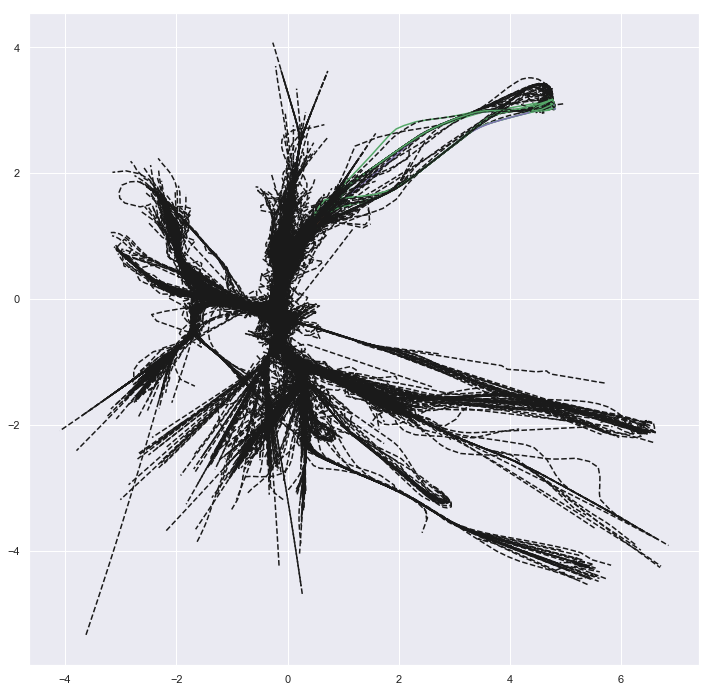

In [100]:
mdl = DBSCAN(eps=3, min_samples=3)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

# Calculate silhouette score for clusters
s_score = silhouette_score(D, cluster_lst, metric='euclidean')
print('\nWhen Silhouette Score score is higher (max=1) when clusters are dense and well separated')
print('For this clustering the silhouette score is: %f' %s_score)

# Calculate Calinski-Harabasz Index for clusters
c_score = metrics.calinski_harabaz_score(D, cluster_lst)
print('\nWhen Calinski-Harabasz score is higher model has better defined clusters')
print('For this clustering the Calinski-Harabasz Index is: %f' %c_score)

# Calculate Davies-Bouldin Index for clusters
d_score = davies_bouldin_score(D, cluster_lst)
print('\nWhen Davies-Bouldin score is lower (min=0) clusters have better separation')
print('For this clustering the Davies-Bouldin Index (lower is better, min=0) is: %f' %d_score)

plot_cluster(traj_lst, cluster_lst)


When Silhouette Score score is higher (max=1) when clusters are dense and well separated
For this clustering the silhouette score is: 0.274419

When Calinski-Harabasz score is higher model has better defined clusters
For this clustering the Calinski-Harabasz Index is: 11599.293407


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances



When Davies-Bouldin score is lower (min=0) clusters have better separation
For this clustering the Davies-Bouldin Index (lower is better, min=0) is: 1.111710


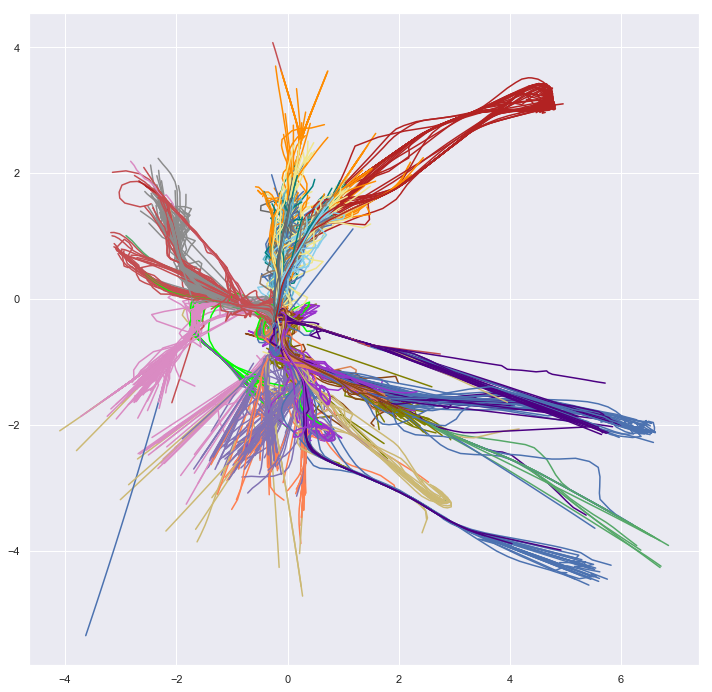

In [101]:
# Use K-Means

# This page:
# https://www.faa.gov/air_traffic/flight_info/aeronav/procedures/application/?event=procedure.results&nasrId=LAX#searchResultsTop
# Shows 24 standard arrival procedures (with more trajectories inside each)

# It shows 38 standard departure procedures (with more trajectories inside each)

from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=23)
# Fitting the input data
kmeans = kmeans.fit(D)
# Getting the cluster labels
cluster_lst = kmeans.predict(D)

# Calculate silhouette score for clusters
s_score = silhouette_score(D, cluster_lst, metric='euclidean')
print('When Silhouette Score score is higher (max=1) when clusters are dense and well separated')
print('For this clustering the silhouette score is: %f' %s_score)

# Calculate Calinski-Harabasz Index for clusters
c_score = metrics.calinski_harabaz_score(D, cluster_lst)
print('\nWhen Calinski-Harabasz score is higher model has better defined clusters')
print('For this clustering the Calinski-Harabasz Index is: %f' %c_score)

# Calculate Davies-Bouldin Index for clusters
d_score = davies_bouldin_score(D, cluster_lst)
print('\nWhen Davies-Bouldin score is lower (min=0) clusters have better separation')
print('For this clustering the Davies-Bouldin Index (lower is better, min=0) is: %f' %d_score)

plot_cluster(traj_lst, cluster_lst)


When Silhouette Score score is higher (max=1) when clusters are dense and well separated
For this clustering the silhouette score is: -0.171293

When Calinski-Harabasz score is higher model has better defined clusters
For this clustering the Calinski-Harabasz Index is: 508.691823


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances



When Davies-Bouldin score is lower (min=0) clusters have better separation
For this clustering the Davies-Bouldin Index (lower is better, min=0) is: 4.912442


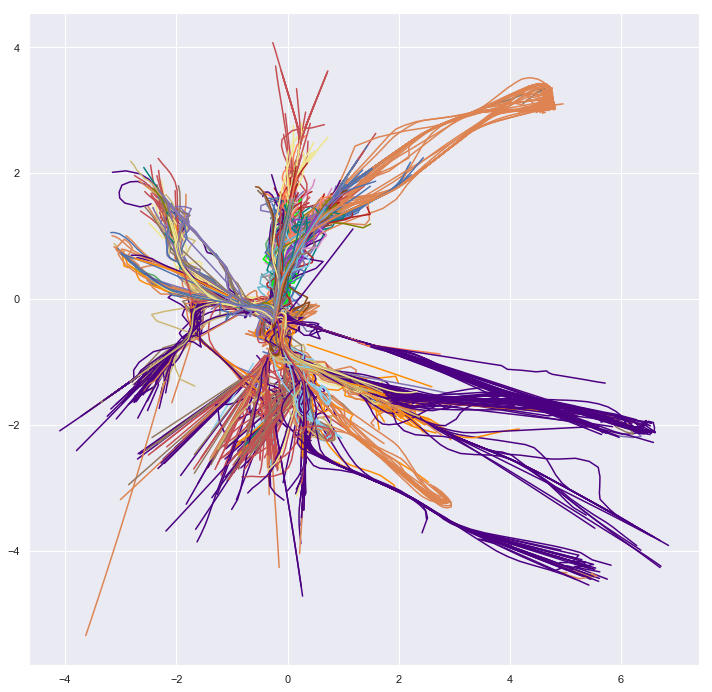

In [102]:
# Use Spectral Clustering

from sklearn.cluster import SpectralClustering

sp = SpectralClustering(n_clusters=23, affinity='precomputed')
sp.fit(D)
cluster_lst = sp.labels_

# Calculate silhouette score for clusters
s_score = silhouette_score(D, cluster_lst, metric='euclidean')
print('When Silhouette Score score is higher (max=1) when clusters are dense and well separated')
print('For this clustering the silhouette score is: %f' %s_score)

# Calculate Calinski-Harabasz Index for clusters
c_score = metrics.calinski_harabaz_score(D, cluster_lst)
print('\nWhen Calinski-Harabasz score is higher model has better defined clusters')
print('For this clustering the Calinski-Harabasz Index is: %f' %c_score)

# Calculate Davies-Bouldin Index for clusters
d_score = davies_bouldin_score(D, cluster_lst)
print('\nWhen Davies-Bouldin score is lower (min=0) clusters have better separation')
print('For this clustering the Davies-Bouldin Index (lower is better, min=0) is: %f' %d_score)

plot_cluster(traj_lst, cluster_lst)


In [103]:
# # Use Gaussian Mixture Model

# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=23).fit(D)
# # These are the predictions for each row as to what class it is in
# cluster_lst = gmm.predict(D)

# # Calculate silhouette score for clusters
# s_score = silhouette_score(D, cluster_lst, metric='euclidean')
# print('When Silhouette Score score is higher (max=1) when clusters are dense and well separated')
# print('For this clustering the silhouette score is: %f' %s_score)

# # Calculate Calinski-Harabasz Index for clusters
# c_score = metrics.calinski_harabaz_score(D, cluster_lst)
# print('\nWhen Calinski-Harabasz score is higher model has better defined clusters')
# print('For this clustering the Calinski-Harabasz Index is: %f' %c_score)

# # Calculate Davies-Bouldin Index for clusters
# d_score = davies_bouldin_score(D, cluster_lst)
# print('\nWhen Davies-Bouldin score is lower (min=0) clusters have better separation')
# print('For this clustering the Davies-Bouldin Index (lower is better, min=0) is: %f' %d_score)

# plot_cluster(traj_lst, cluster_lst)


/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


When Silhouette Score score is higher (max=1) when clusters are dense and well separated
For this clustering the silhouette score is: 0.233933

When Calinski-Harabasz score is higher model has better defined clusters
For this clustering the Calinski-Harabasz Index is: 10421.749249


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances



When Davies-Bouldin score is lower (min=0) clusters have better separation
For this clustering the Davies-Bouldin Index (lower is better, min=0) is: 1.088832


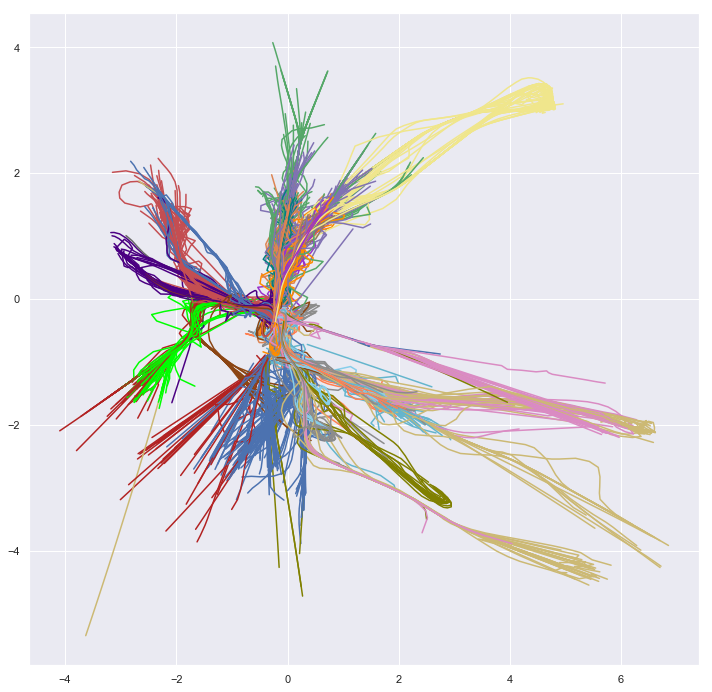

In [104]:
# Use Agglomerative Clustering

from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(linkage='ward', n_clusters=23)
model.fit(D)
cluster_lst = model.labels_

# Calculate silhouette score for clusters
s_score = silhouette_score(D, cluster_lst, metric='euclidean')
print('When Silhouette Score score is higher (max=1) when clusters are dense and well separated')
print('For this clustering the silhouette score is: %f' %s_score)

# Calculate Calinski-Harabasz Index for clusters
c_score = metrics.calinski_harabaz_score(D, cluster_lst)
print('\nWhen Calinski-Harabasz score is higher model has better defined clusters')
print('For this clustering the Calinski-Harabasz Index is: %f' %c_score)

# Calculate Davies-Bouldin Index for clusters
d_score = davies_bouldin_score(D, cluster_lst)
print('\nWhen Davies-Bouldin score is lower (min=0) clusters have better separation')
print('For this clustering the Davies-Bouldin Index (lower is better, min=0) is: %f' %d_score)

plot_cluster(traj_lst, cluster_lst)


In [105]:
# Definition for printing particular clusters
def plot_single_cluster(traj_lst, cluster_lst,chosen_cluster):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        if not cluster==chosen_cluster:
            continue
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    
    plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


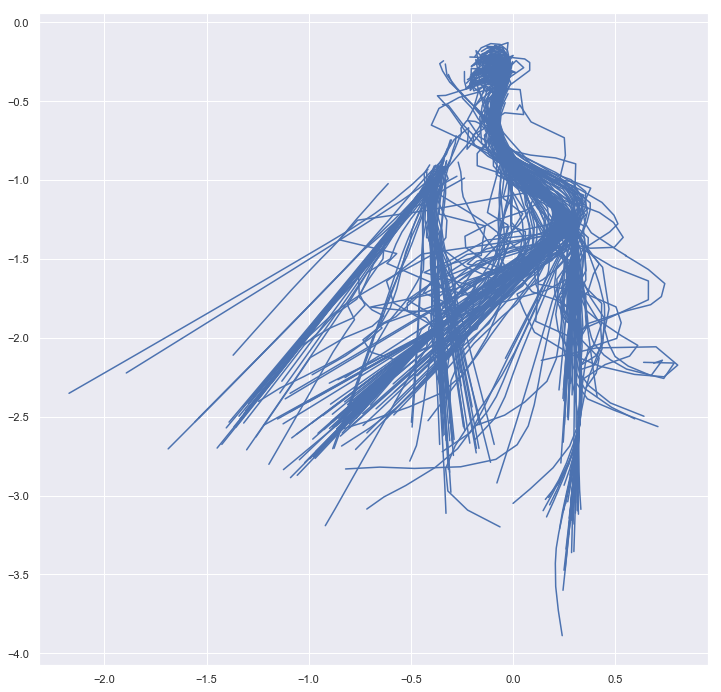

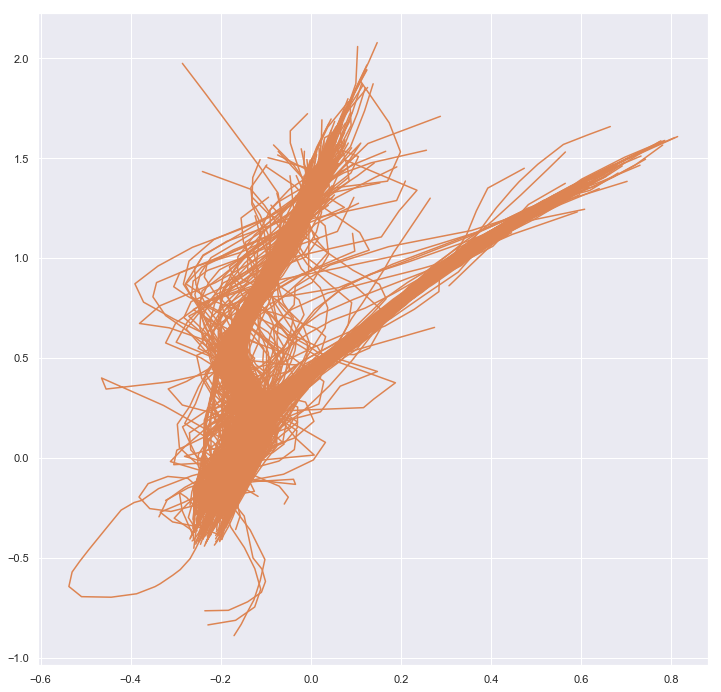

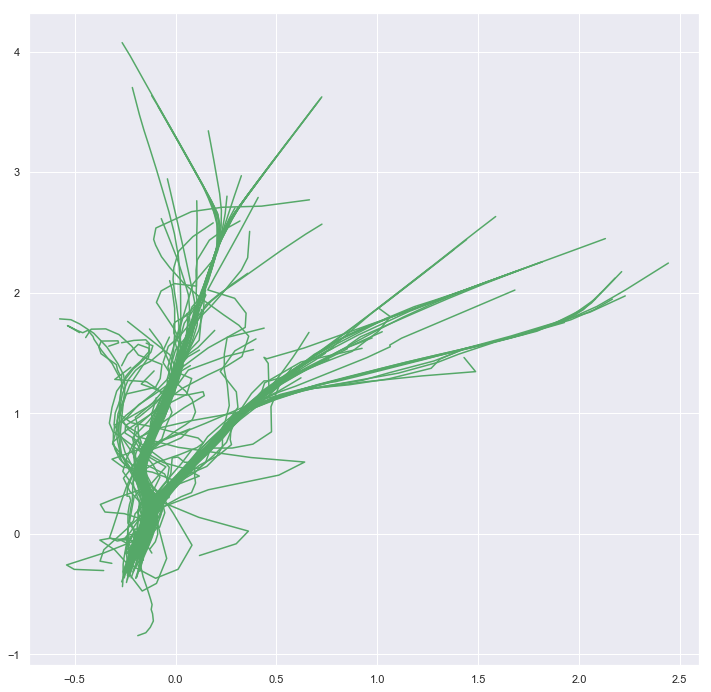

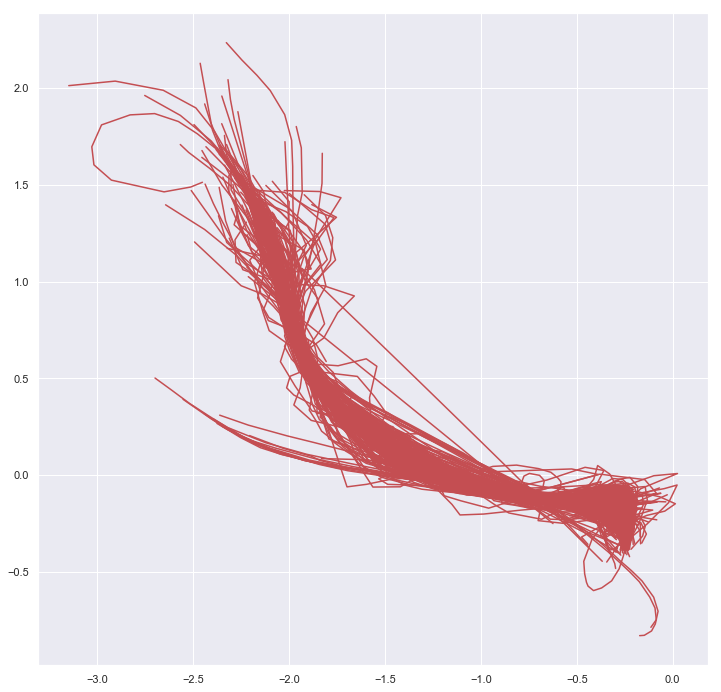

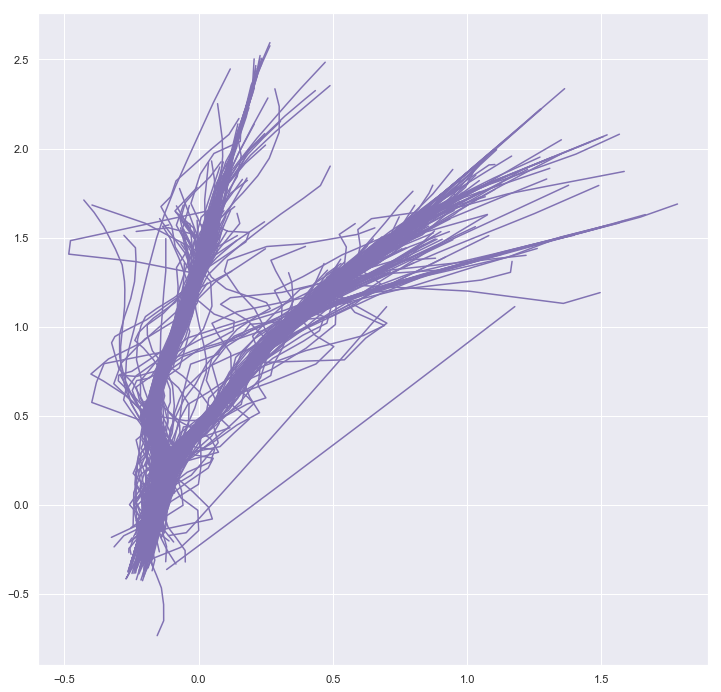

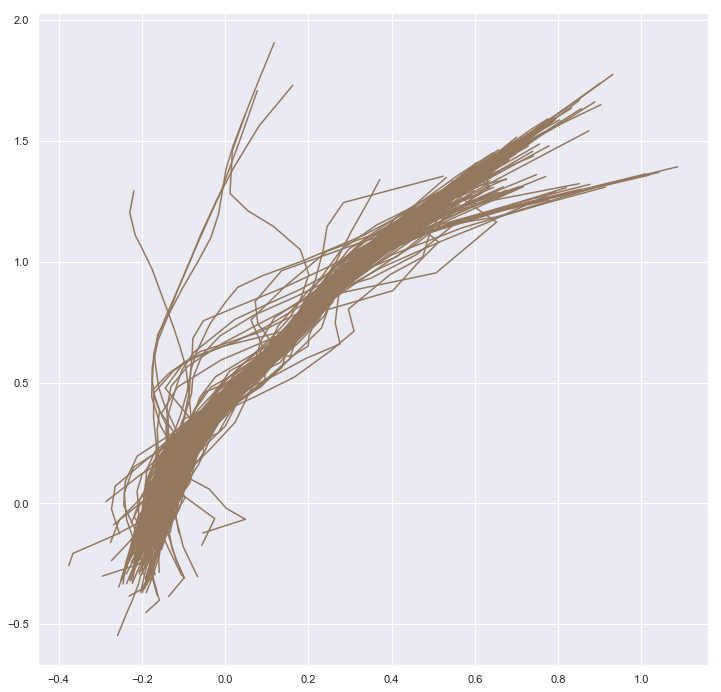

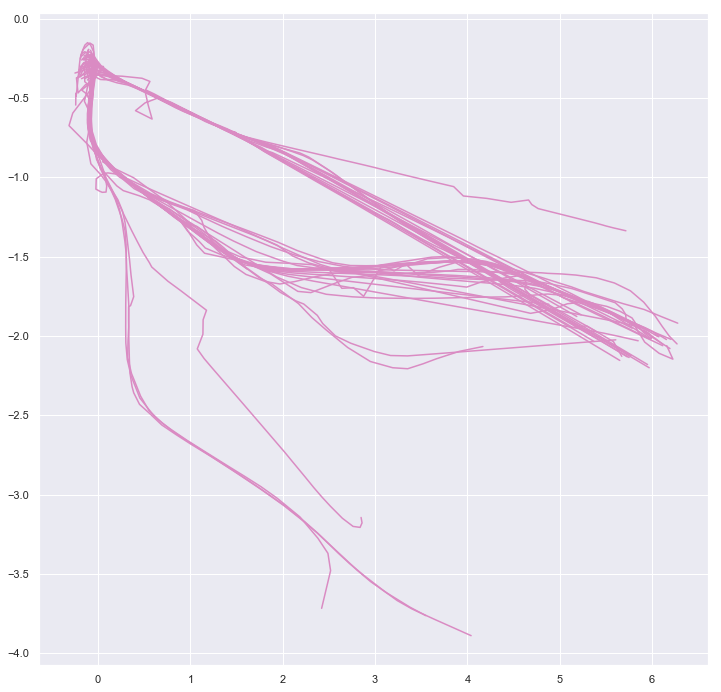

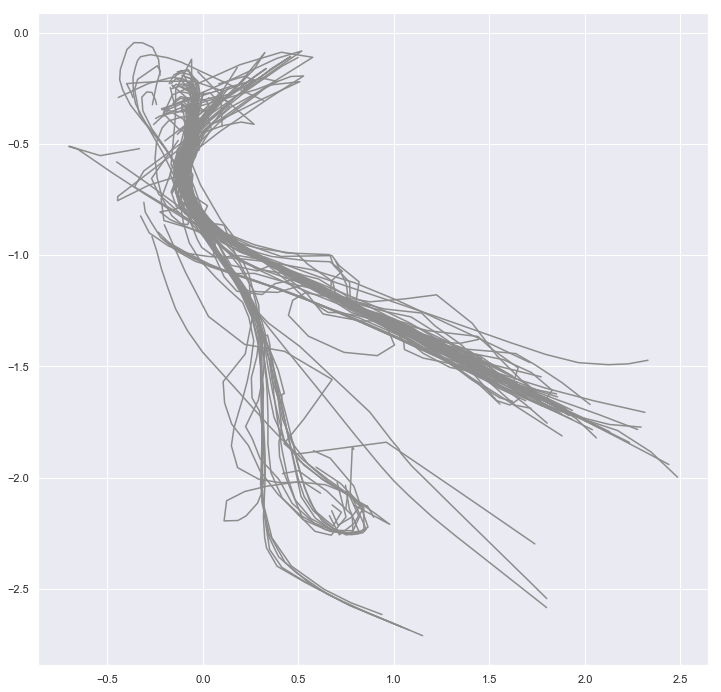

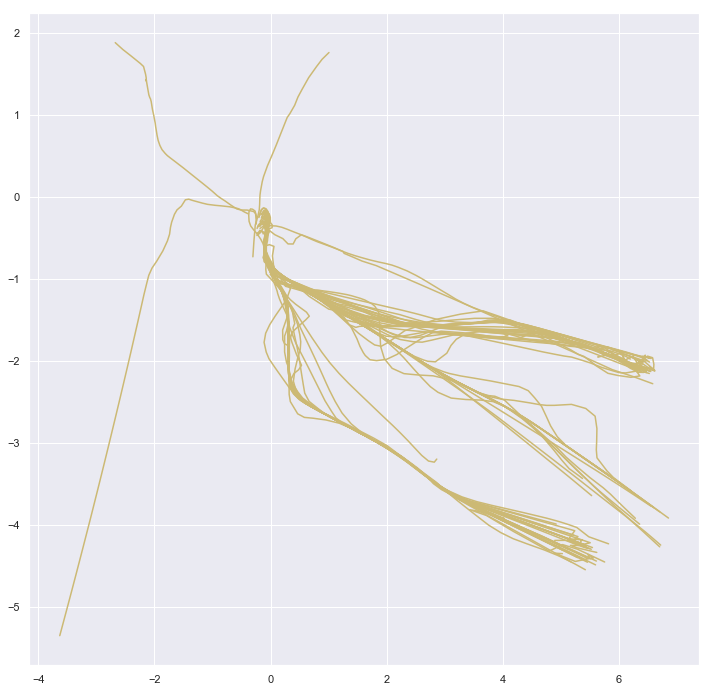

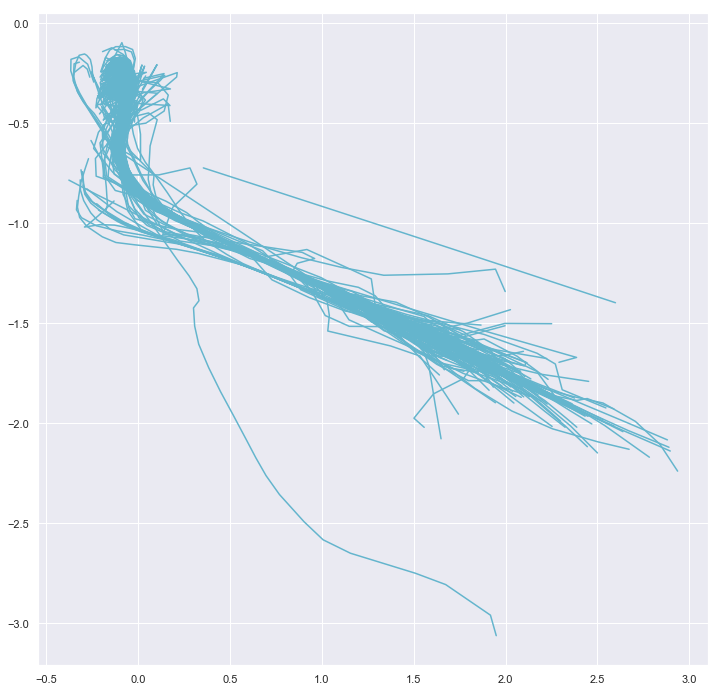

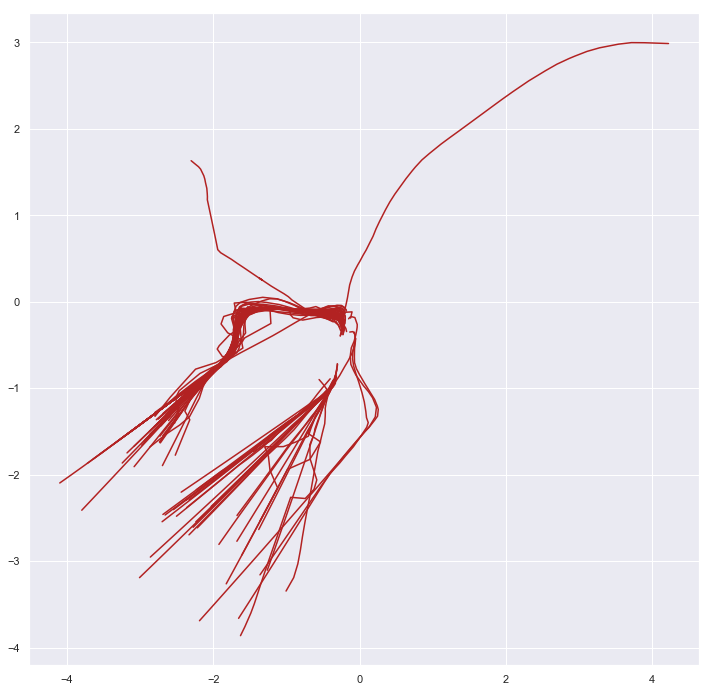

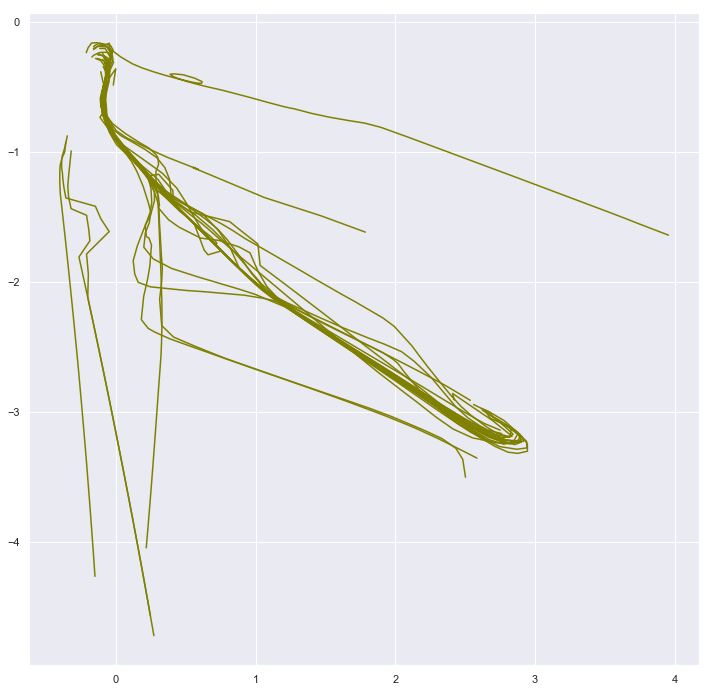

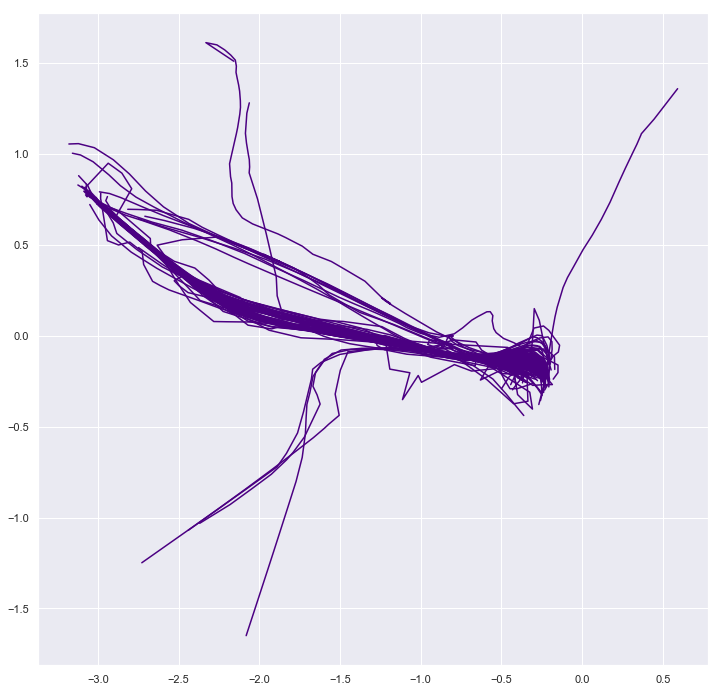

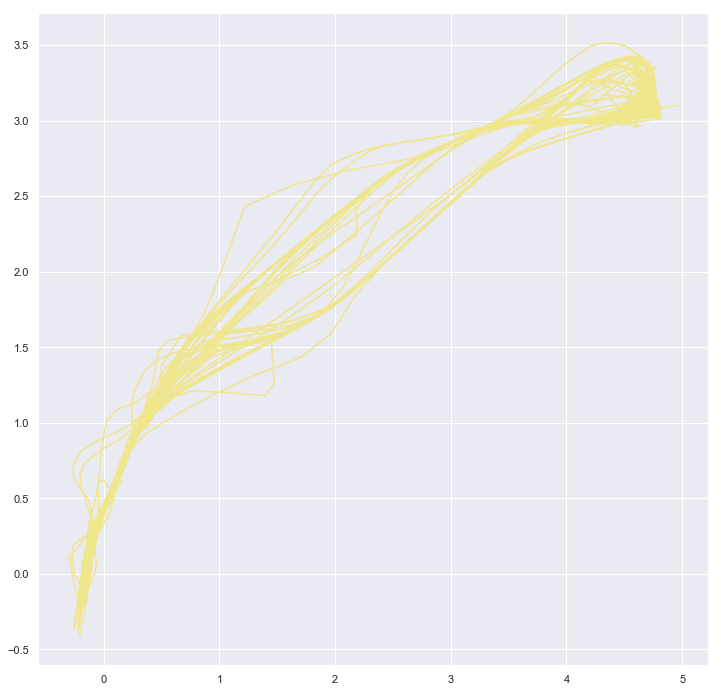

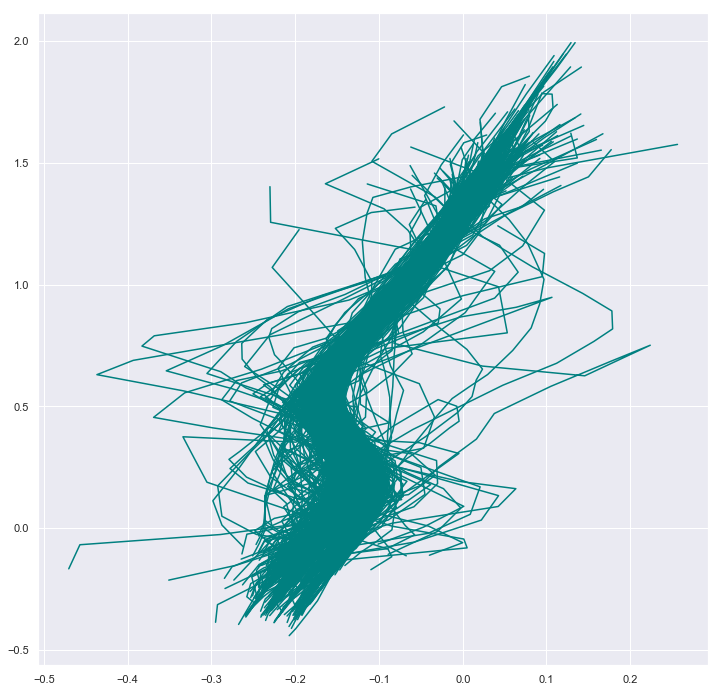

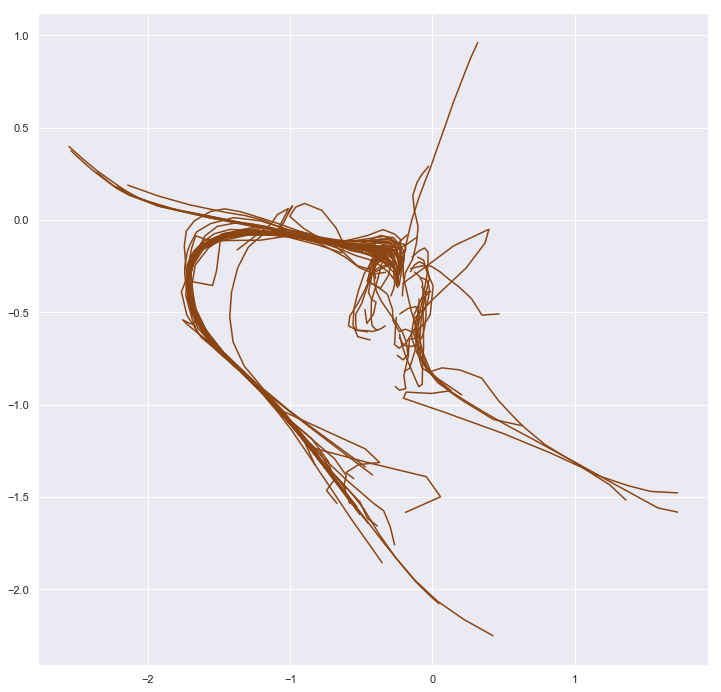

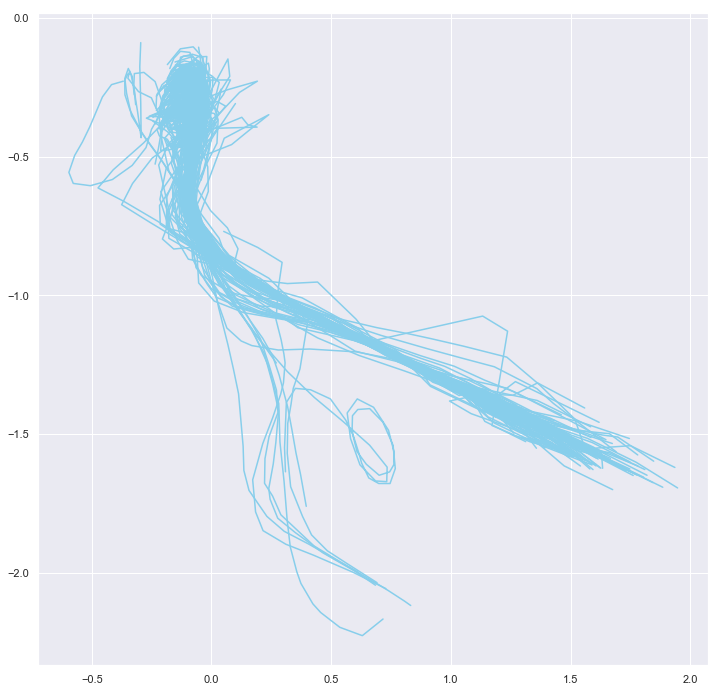

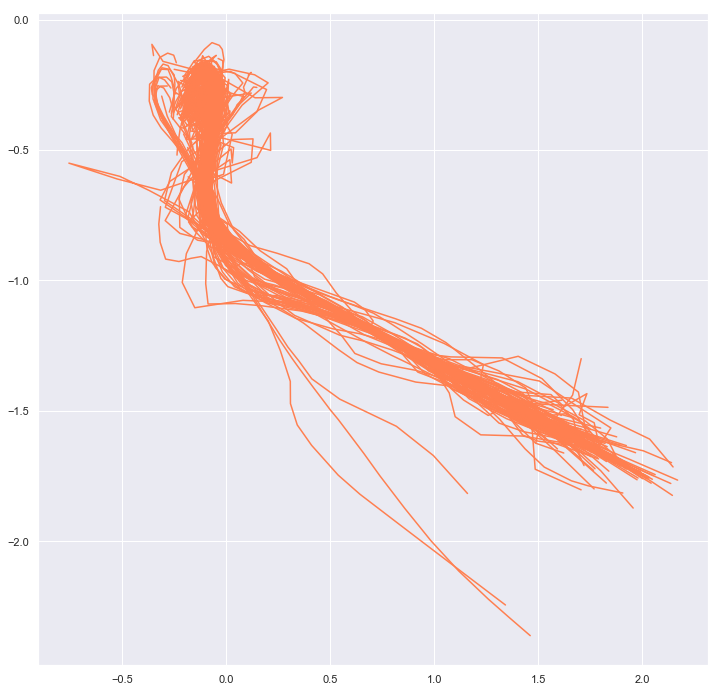

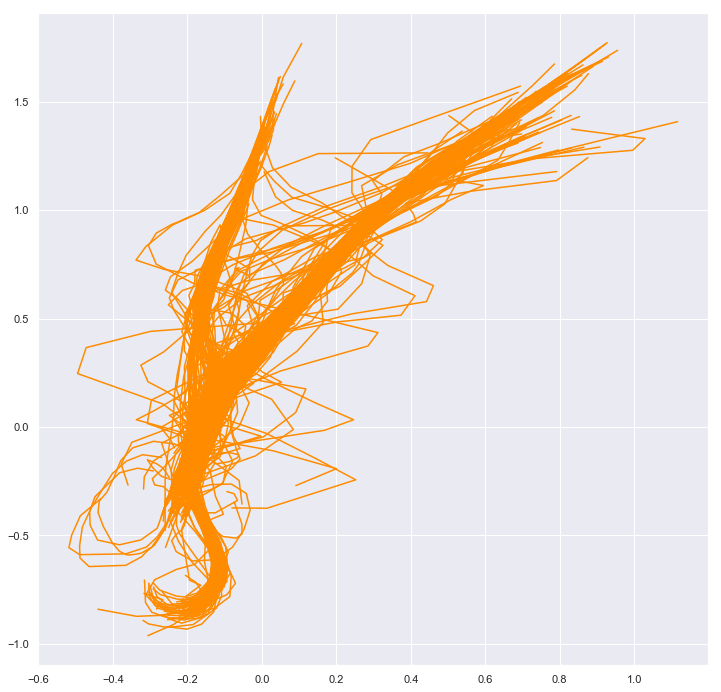

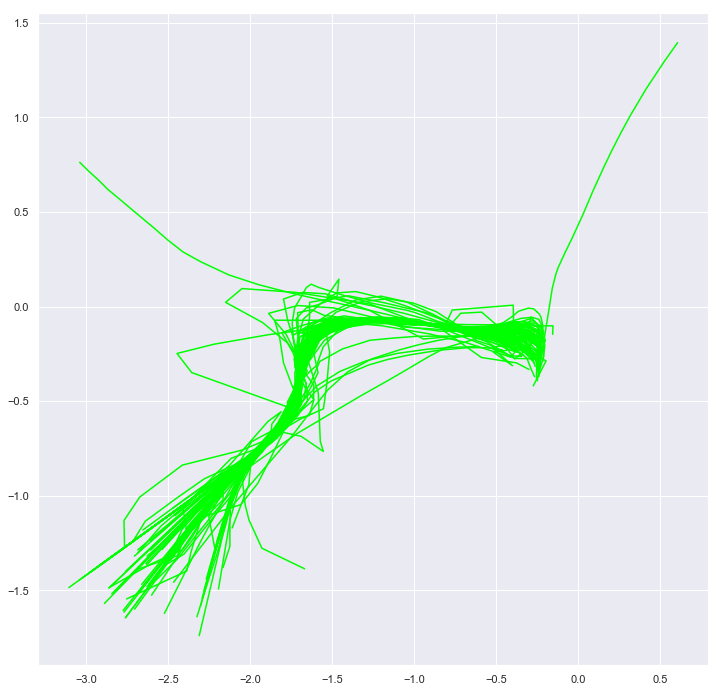

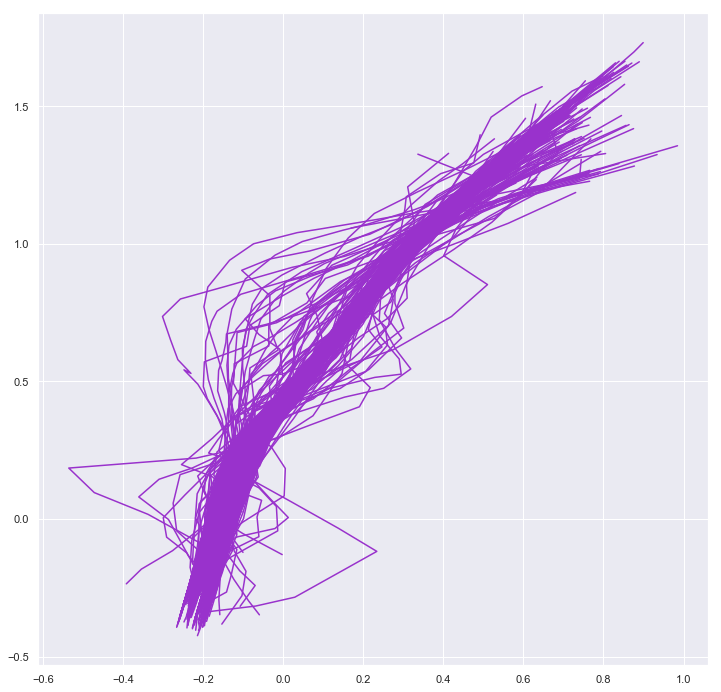

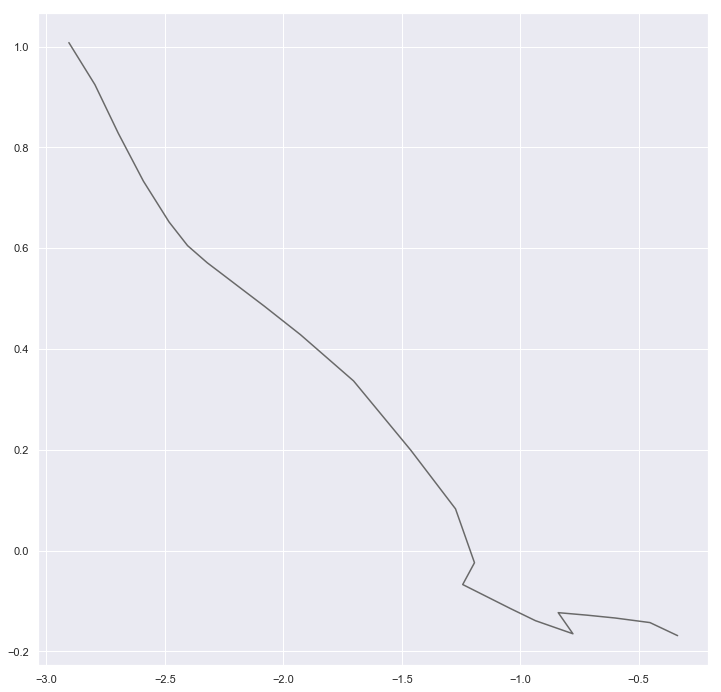

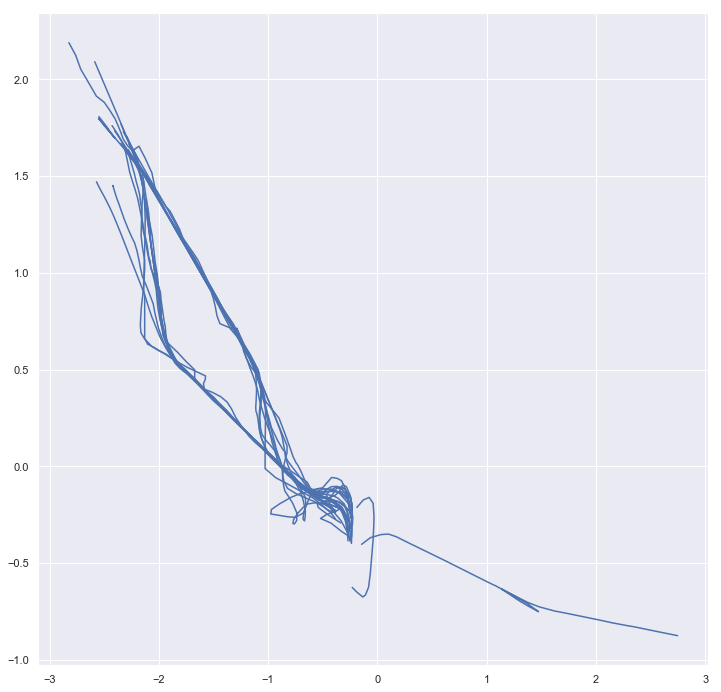

In [106]:
print(np.unique(cluster_lst))

for cluster in np.unique(cluster_lst):
    plot_single_cluster(traj_lst, cluster_lst, cluster)

In [316]:
# Read in the known latitudes and longitudes for waypoints

f = open("/Users/bryan/Box Sync/_Airport-Planning-Solutions/28DaySubscription_Effective_2019-06-20/NATFIX.txt", "r")
prev_code = 'S0000'
code_list = []
name_list = []
proc_vers_list = []

lax_coord = [33.9416, -118.4085]
lat_lon_range = 10
# Range of latitudes and longitudes around LAX to include
lat_min = lax_coord[0] - lat_lon_range
lat_max = lax_coord[0] + lat_lon_range
lon_min = lax_coord[1] - lat_lon_range
lon_max = lax_coord[1] + lat_lon_range

waypt_name_list = []
waypt_lat_list = []
waypt_lon_list = []
for line in f:
    
    line = line.split()
    
    # Skip if not holding full information
    if len(line)<4:
        continue
        
    waypt_name = line[1]
    waypt_name_list.append(waypt_name)
    
    waypt_lat = line[2]
    if waypt_lat[-1]=='N':
        waypt_lat = float(waypt_lat[:-1])/(10**4)
    else:
        waypt_lat = -float(waypt_lat[:-1])/(10**4)
    waypt_lat_list.append(waypt_lat)
    
    waypt_lon = line[3]
    if waypt_lon[-1]=='E':
        waypt_lon = float(waypt_lon[:-1])/(10**4)
    else:
        waypt_lon = -float(waypt_lon[:-1])/(10**4)
    waypt_lon_list.append(waypt_lon)

# Turn into Pandas DataFrame
waypt_df = pd.DataFrame({'Name':waypt_name_list, 'Latitude':waypt_lat_list,
                        'Longitude':waypt_lon_list})

# Now filter out all procedures not anywhere near LAX
skip_list = [True] * waypt_df.shape[0]
for index in range(waypt_df.shape[0]):
    temp_waypt = waypt_df.loc[index]
    temp_lat = float(temp_waypt.Latitude)
    temp_lon = float(temp_waypt.Longitude)
                
    # Only include if flight contains points near LAX
    if (temp_lat<lat_min or temp_lat>lat_max):
        skip_list[index] = False
    if (temp_lon<lon_min or temp_lon>lon_max):
        skip_list[index] = False

# Before returning filter out those rows flagged as being skipped
waypt_df = waypt_df[skip_list]
waypt_df.reset_index(inplace=True,drop = True)

waypt_df.head()


Name  Latitude  Longitude
0  00CA   35.2118  -116.5307
1  00CL   39.2538  -121.4548
2  00CN   32.4339  -116.2735
3  01AZ   34.3629  -111.5153
4  01CA   34.2206  -117.2212

In [317]:
# Manually add some waypoints into the dataframe
waypt_df = waypt_df.append({'Name':'JULIAN','Latitude':33.14527778,'Longitude':-116.58777778} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'OCEANSIDE','Latitude':33.24555556,'Longitude':-117.41833333} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'SEAL BEACH','Latitude':33.78333333,'Longitude':-118.05805556} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'TWENTYNINE PALMS','Latitude':34.12027778,'Longitude':-115.77194444} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'AVENAL','Latitude':35.65611111,'Longitude':-119.98666667} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'FILLMORE','Latitude':34.36111111,'Longitude':-118.89111111} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'SANTA MONICA','Latitude':34.01694444,'Longitude':-118.46111111} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'SAN MARCUS','Latitude':34.51583333,'Longitude':-119.77388889} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'VENTURA','Latitude':34.12500000,'Longitude':-119.06027778} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'PALMDALE','Latitude':34.64222222,'Longitude':-118.07305556} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'SANTA CATALINA','Latitude':33.38055556,'Longitude':-118.42194444} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'CFBZK','Latitude':33.30611111,'Longitude':-117.88916667} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'LAKE HUGHES','Latitude':34.69388889,'Longitude':-118.58388889} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'SHAFTER','Latitude':35.48527778,'Longitude':-119.10666667} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'TULE','Latitude':35.92166667,'Longitude':-119.02361111} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'HECTOR','Latitude':34.80611111,'Longitude':-116.47166667} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'PARADISE','Latitude':33.91944444,'Longitude':-117.53888889} , ignore_index=True)
waypt_df = waypt_df.append({'Name':'PEACH SPRINGS','Latitude':35.63000000,'Longitude':-113.55194444} , ignore_index=True)






In [384]:
# Read in arrival trajectory data
traj_df = pd.read_excel('/Users/bryan/Box Sync/_Airport-Planning-Solutions/STAR.xlsx',encoding = "ISO-8859-1")
traj_df.head()

# Now go through each manually created trajectory and replace name of waypoint with lat,lon from above
for index in range(traj_df.shape[0]):
    # cut off [[ at beginning and ]] at the end
    curr_traj = str(traj_df.iloc[index].Trajectory[2:-2])
    split_traj = curr_traj.split('],[')
    
    new_traj = []
    for point in split_traj:
        # Split by comma
        name,orientation = point.split(',')
        if orientation=='nan':
            orientation = np.nan
        else:
            orientation = int(orientation)
        temp = waypt_df.loc[waypt_df.Name==name]
        
        corr_lat = temp.Latitude.values
        corr_lon = temp.Longitude.values
        
        if len(corr_lat)==0:
            print('The below point has not been coded in yet...')
            print(traj_df.loc[index]['NAME (ARRIVAL)'])
            print(traj_df.loc[index]['TRANSITION NAME'])
            print(name)
        else:
            new_traj.append((corr_lat[0],corr_lon[0],orientation))
#     print(new_traj)
            
    # Now insert new trajectories back into main dataframe
    traj_df.iloc[index].Trajectory = new_traj
    
traj_df.head()

NAME (ARRIVAL) TRANSITION NAME  \
0    Zuuma Three           BURGL   
1    Zuuma Three           REBRG   
2      WAYVE ONE     LAKE HUGHES   
3      WAYVE ONE           LOPES   
4      WAYVE ONE         SHAFTER   

                                          Trajectory  
0  [(35.3958, -120.0628, 136), (35.172, -119.4927...  
1  [(35.5853, -119.3653, 185), (35.4001, -119.435...  
2  [(34.3422, -118.3044, 142), (34.2948, -118.280...  
3  [(35.0155, -118.4205, 152), (34.5036, -118.380...  
4  [(35.0155, -118.4205, 152), (34.5036, -118.380...

In [395]:
df_plot = traj_df.copy(deep=True)

# Range of planes to plot
plot_min=0
plot_max=traj_df.shape[0]

p = figure(title="Standard Procedures For Arriving To LAX")

color_mapper = linear_cmap('index', inferno(256), plot_min, plot_max)

for i in range(plot_min,plot_max):

    # Overlay all flights on each other
    temp_df = df_plot.iloc[i-1:i]
    
    # Gather list of latitude and longitude points for each flight separately
    for elem in temp_df.Trajectory:
        lat = [item[0] for item in elem]
        lon = [item[1] for item in elem]
        
        index_list = np.ones(len(lat))*i
        source = ColumnDataSource(
            data=dict(lat=lat,
                      lon=lon,
                      index=index_list)
        )

        p.line(lon, lat, line_width=2, line_alpha=0.1)

output_notebook()  
show(p)

Loading BokehJS ...

In [358]:
print(traj_df.iloc[0:1].Trajectory)

0    [(35.0729, -115.344, 214), (34.4628, -116.0126...
Name: Trajectory, dtype: object
